# Knowledge Embedding with Pykeen
## 概要
- 知識グラフから知識グラフの埋め込みモデルを学習する．
- pykeenにあらかじめ入っているデータセットに関しては，この[GitHub](https://github.com/pykeen/benchmarking)のページを参考にハイパーパラメータを設定．
## 入力データ・パラメータ
- 知識グラフ埋め込みモデル名
- 知識グラフ
- ランダムシード（optional）
## 出力データ
- 各ランダムシードの知識グラフ
- メタデータ

## modules

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm
from pykeen.pipeline import pipeline
from pykeen.datasets import get_dataset

from util.databinder import DataBinder

/tmp/42813980.1.gpu/ipykernel_299994/3913572063.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## functions

In [30]:
def convert_dtype(value):
    if isinstance(value, np.floating):
        return float(value)
    elif isinstance(value, np.integer):
        return int(value)
    else:
        return value

def delete_all_files_in_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            shutil.rmtree(dir_path)

def get_best_params(f_params:str, model_name:str, dataset_name:str):
    """
    最適なハイパーパラメータを取得する．
    TODO:
        洗練されていないので修正すること．
    """
    df_best_params = pd.read_pickle(f_params).reset_index()
    df_best_params = df_best_params[df_best_params['model'].isin([model_name])]
    df_best_params = df_best_params[df_best_params['dataset'].isin([dataset_name])]
    
    dict_args = {}
    idx = 0
    
    dict_args['dataset'] = df_best_params.loc[idx,'dataset']
    
    dict_args['dataset_kwargs'] = {}
    for k, v in df_best_params.filter(regex='pipeline_config.pipeline.dataset_kwargs').loc[idx].items():
        if not np.isnan(v):
            dict_args['dataset_kwargs'][k.split('.')[-1]] = v

    dict_args['evaluator'] = df_best_params.loc[idx,'evaluator']

    dict_args['evaluator_kwargs'] = {}
    for k, v in df_best_params.filter(regex='pipeline_config.pipeline.evaluator_kwargs').loc[idx].items():
        if not np.isnan(v):
            dict_args['evaluator_kwargs'][k.split('.')[-1]] = v
    
    dict_args['model'] = df_best_params.loc[idx,'model']

    dict_args['loss'] = df_best_params.loc[idx, 'loss']

    dict_args['regularizer'] = df_best_params.loc[idx, 'regularizer']

    dict_args['optimizer'] = df_best_params.loc[idx, 'optimizer']

    dict_args['optimizer_kwargs'] = {}
    for k, v in df_best_params.filter(regex='pipeline_config.pipeline.optimizer_kwargs').loc[idx].items():
        if not np.isnan(v) and 'automatic_memory_optimization' not in k:
            dict_args['optimizer_kwargs'][k.split('.')[-1]] = convert_dtype(v)
    
    dict_args['model_kwargs'] = {}
    for k, v in df_best_params.filter(regex='pipeline_config.pipeline.model_kwargs').loc[idx].items():
        if not np.isnan(v) and 'automatic_memory_optimization' not in k:
            k = k.split('.')[-1]
            if k in ['output_channels', 'kernel_height', 'kernel_width']:
                v = int(v)    
            dict_args['model_kwargs'][k] = convert_dtype(v)

    dict_args['training_loop'] = df_best_params.loc[idx, 'training_loop']

    dict_args['training_kwargs'] = {}
    for k, v in df_best_params.filter(regex='pipeline_config.pipeline.training_kwargs').loc[idx].items():
        if not np.isnan(v):
            k = k.split('.')[-1]
            if k in ['batch_size', 'num_epochs']:
                v = int(v)

            #if k not in ['label_smoothing']:
            #    dict_args['training_kwargs'][k.split('.')[-1]] = v
            dict_args['training_kwargs'][k.split('.')[-1]] = v

    return dict_args

## parameters

In [31]:
# for input
# ----------------------------------------------------
## a path to the data fra
f_params = '../benchmarking/df_best_param.pkl'
## a name of knowledge graph embedding model
model_name = 'transe'
## a data set (knowledge graph)
dataset_name = 'fb15k237'
## a list of random seeds which should be unique for each other
list_random_seeds = [0]
## a number of epochs (if None, using best value)
num_epochs = None
## if using defalut values for hyper parameters
use_default = False


# for output
# ----------------------------------------------------
## a direcory where learned model are saved
del_previous_result = True
output_name = 'try2'
dir_learned_model = f'./models/20240803/kge_{output_name}_{model_name}_{dataset_name}'

## preparation

In [32]:
if del_previous_result:
    delete_all_files_in_directory(dir_learned_model)
if not os.path.exists(dir_learned_model):
    os.mkdir(dir_learned_model)
db = DataBinder(dir_learned_model)

INFO:root:Create ./models/20240803/kge_try2_transe_fb15k237/info.json


## main

In [33]:
dict_args = get_best_params(f_params, model_name, dataset_name)

In [34]:
if num_epochs != None:
    dict_args['training_kwargs']['num_epochs'] = num_epochs

In [35]:
dict_args

{'dataset': 'fb15k237',
 'dataset_kwargs': {'create_inverse_triples': True},
 'evaluator': 'rankbased',
 'evaluator_kwargs': {'filtered': True},
 'model': 'transe',
 'loss': 'crossentropy',
 'regularizer': 'no',
 'optimizer': 'adam',
 'optimizer_kwargs': {'lr': 0.0016608460884079, 'weight_decay': 0.0},
 'model_kwargs': {'embedding_dim': 64, 'scoring_fct_norm': 1.0},
 'training_loop': 'lcwa',
 'training_kwargs': {'batch_size': 256,
  'label_smoothing': 0.717650072390557,
  'num_epochs': 201}}

INFO:pykeen.datasets.utils:Loading cached preprocessed dataset from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.triples.triples_factory:Loading from file:///home/acg16558pn/.data/pykeen/datasets/fb15k237/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/validation
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.stoppers.early_stopping:Inferred checkpoint path for best model weights: /home/acg16558pn/.data/pykeen/checkpoints/best-model-weights-d244a383-3170-4f7f-b71a-69289d149c02.pt
INFO:pykeen.triples.triples_factory:Creating inverse triples.


--------------------
learn knoweldge graph embedding with random seed 0


Training epochs on cuda:0:   0%|          | 0/201 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=1024.
INFO:pykeen.evaluation.evaluator:Evaluation took 2.04s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 50: 0.0031667237247517974. Saved model weights to /home/acg16558pn/.data/pykeen/checkpoints/best-model-weights-d244a383-3170-4f7f-b71a-69289d149c02.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 50.


Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.77s seconds
INFO:pykeen.stoppers.early_stopping:New best result at epoch 100: 0.004279356384799726. Saved model weights to /home/acg16558pn/.data/pykeen/checkpoints/best-model-weights-d244a383-3170-4f7f-b71a-69289d149c02.pt
INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 100.


Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.99s seconds


Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0/2126 [00:00<?, ?batch/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 1.81s seconds
INFO:pykeen.stoppers.early_stopping:Stopping early at epoch 200. The best result 0.004279356384799726 occurred at epoch 100.
INFO:pykeen.stoppers.early_stopping:Re-loading weights from best epoch from /home/acg16558pn/.data/pykeen/checkpoints/best-model-weights-d244a383-3170-4f7f-b71a-69289d149c02.pt
INFO:root:When evaluating the test dataset after running the pipeline with early stopping, the validation triples are added to the set of known positive triples which are filtered out when performing filtered evaluation following the approach described by (Bordes et al., 2013).


Evaluating on cuda:0:   0%|          | 0.00/20.4k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 2.07s seconds


--------------------
RESULT	0.004452490458949017


INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14505, num_relations=474, create_inverse_triples=True, num_triples=272115, path=Release/train.txt) to file:///home/acg16558pn/programs/Analysis-of-conventional-refinement-method-for-knowledge-graph/models/20240803/kge_try2_transe_fb15k237/0/training_triples
INFO:pykeen.pipeline.api:Saved to directory: file:///home/acg16558pn/programs/Analysis-of-conventional-refinement-method-for-knowledge-graph/models/20240803/kge_try2_transe_fb15k237/0
INFO:root:Saved info at 2024-08-08 04:08:38


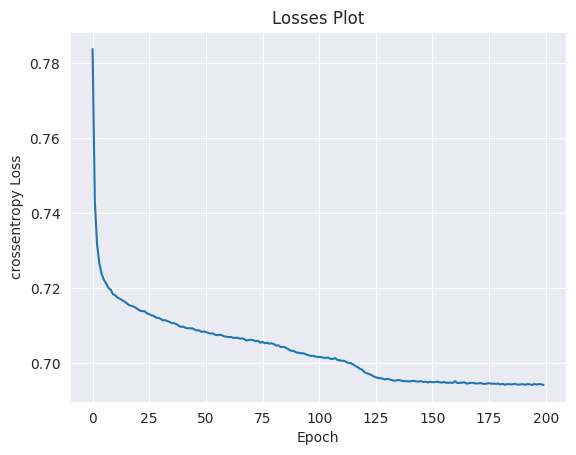

In [36]:
for random_seed in list_random_seeds:

    print(20*'-')
    print(f'learn knoweldge graph embedding with random seed {random_seed}')

    if use_default:
        pipeline_result = pipeline(
            dataset=dict_args['dataset'],
            model= dict_args['model'],
            random_seed=random_seed
        )

    else:
        pipeline_result = pipeline(
            dataset=dict_args['dataset'],
            dataset_kwargs = dict_args['dataset_kwargs'],
            evaluator=dict_args['evaluator'],
            evaluator_kwargs = dict_args['evaluator_kwargs'],
            loss = dict_args['loss'],
            model= dict_args['model'],
            model_kwargs = dict_args['model_kwargs'],    
            training_kwargs=dict_args['training_kwargs'],
            optimizer=dict_args['optimizer'],
            optimizer_kwargs=dict_args['optimizer_kwargs'],
            stopper='early',
            stopper_kwargs={'frequency':50, 'patience':2, 'relative_delta':0.002},
            random_seed=random_seed
        )

    pipeline_result.plot_losses()

    hits_at_10 = pipeline_result.get_metric('hits_at_10')
    print(20*'-')
    print('RESULT\t' + str(hits_at_10))

    dir_save = f'{dir_learned_model}/{random_seed}'
    if not os.path.exists(dir_save):
        os.mkdir(dir_save)
    pipeline_result.save_to_directory(dir_save)

    db.add(f'model_{random_seed}', pipeline_result.model)

In [8]:
db.add('model_name', model_name)
db.add('dataset_name', dataset_name)
db.add('dict_args', dict_args)
db.add('f_params', f_params)
db.add('list_random_seeds', list_random_seeds)

INFO:root:Saved info at 2024-08-07 05:37:43
INFO:root:Saved info at 2024-08-07 05:37:43
INFO:root:Saved info at 2024-08-07 05:37:43
INFO:root:Saved info at 2024-08-07 05:37:43
INFO:root:Saved info at 2024-08-07 05:37:43


'./models/20240803/kge_try2_transe_fb15k237/list_random_seeds.pt'